In [1]:
#%matplotlib widget
#%matplotlib ipympl
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import mne

from matplotlib import pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.classification import MDM, TSclassifier

## Configuration

In [3]:
filename = '../data/oddball.hdf5'
group_data = 'eeg'
group_events = 'events'
channels = ['Fp1', 'Fp2', 'C3', 'Cz', 'C4', 'O1', 'O2']

## Convert to MNE

Load data

In [4]:
store = pd.HDFStore(filename, mode='r')
df = store.select(group_data, columns=channels)
times = df.index.values.astype('int') * 1e-9
data = df.values.T * 1e-6
rate = store.get_node(group_data)._v_attrs['meta']['rate']
df

,Fp1,Fp2,C3,Cz,C4,O1,O2
2020-01-10 09:29:41.188935041,21.457672,-9.238720,-62.882900,-18.477440,-19.669533,-22.649765,-16.391277
2020-01-10 09:29:41.192934990,-0.596046,-2.384186,-98.943710,-29.802322,-28.014183,-32.484531,-24.139881
2020-01-10 09:29:41.196935177,12.218952,22.351742,-29.206276,8.344650,4.470348,-18.477440,-16.987324
2020-01-10 09:29:41.200935125,35.762787,-5.662441,28.014183,35.762787,33.676624,-5.960464,-9.536743
2020-01-10 09:29:41.204935074,22.053719,-32.484531,67.353249,49.471855,47.087669,-4.172325,-3.874302
...,...,...,...,...,...,...,...
2020-01-10 10:00:12.706778526,318.586823,153.779984,388.026245,95.069412,184.476379,35.762787,-4.470348
2020-01-10 10:00:12.710778475,202.655792,38.146973,-191.330902,-86.128708,-159.740448,-34.272671,-29.802322
2020-01-10 10:00:12.714778662,163.018707,-0.596046,-323.951233,-98.049637,-198.483459,-54.836273,-40.531158
2020-01-10 10:00:12.718778610,204.741959,42.021275,-74.505806,-27.418137,-49.769878,-29.802322,-34.272671


Load events

In [5]:
df = store.select(group_events)
onsets = df.loc[df['label'] == 'stim_on'].index.values.astype('int') * 1e-9
labels = df.loc[df['label'] == 'stim_begins']['data'].str.contains('true').replace({False: 'standard', True: 'deviant'}).values
annotations = mne.Annotations(onsets, 0, labels, orig_time=0)
df

,label,data
2020-01-10 09:33:07.463510009,session_begins,NaN
2020-01-10 09:33:07.463885010,block_begins,NaN
2020-01-10 09:33:07.463989990,stim_begins,"{""on"":100,""off"":1157,""deviant"":false}"
2020-01-10 09:33:07.499645020,stim_on,NaN
2020-01-10 09:33:07.606280029,stim_off,NaN
...,...,...
2020-01-10 09:59:46.756405029,stim_on,NaN
2020-01-10 09:59:46.872790039,stim_off,NaN
2020-01-10 09:59:48.105199951,stim_ends,NaN
2020-01-10 09:59:48.105290039,block_ends,NaN


Create MNE raw object

In [6]:
info = mne.create_info(ch_names=channels, sfreq=rate, ch_types='eeg')
info.set_montage('standard_1020')
raw = mne.io.RawArray(data, info)
raw.set_meas_date(times[0])
raw.set_annotations(annotations)

Creating RawArray with float64 data, n_channels=7, n_times=457888
    Range : 0 ... 457887 =      0.000 ...  1831.548 secs
Ready.


<RawArray | 7 x 457888 (1831.5 s), ~24.5 MB, data loaded>

## Preprocessing

Plot the raw data

Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


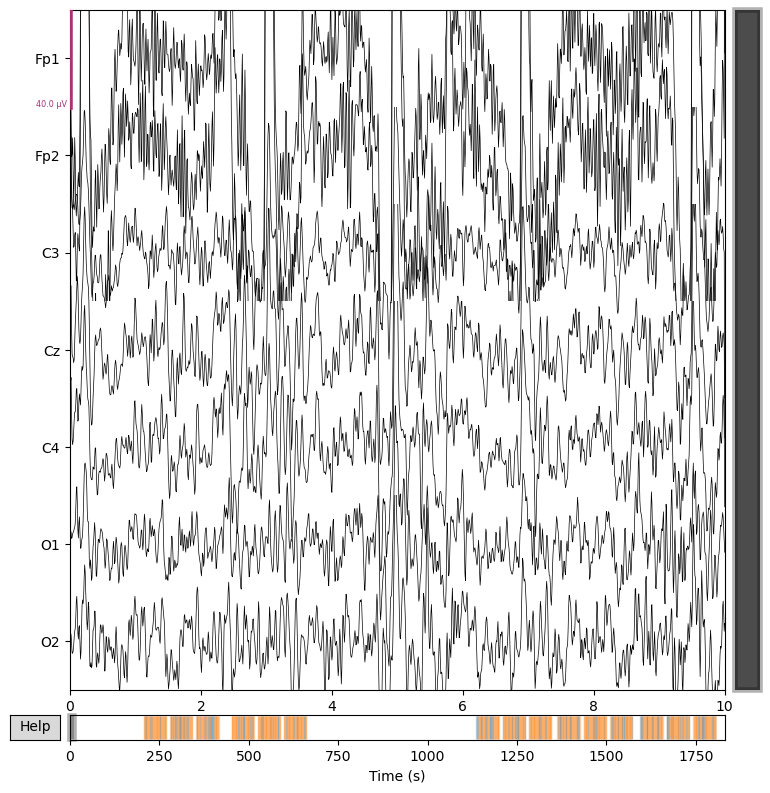

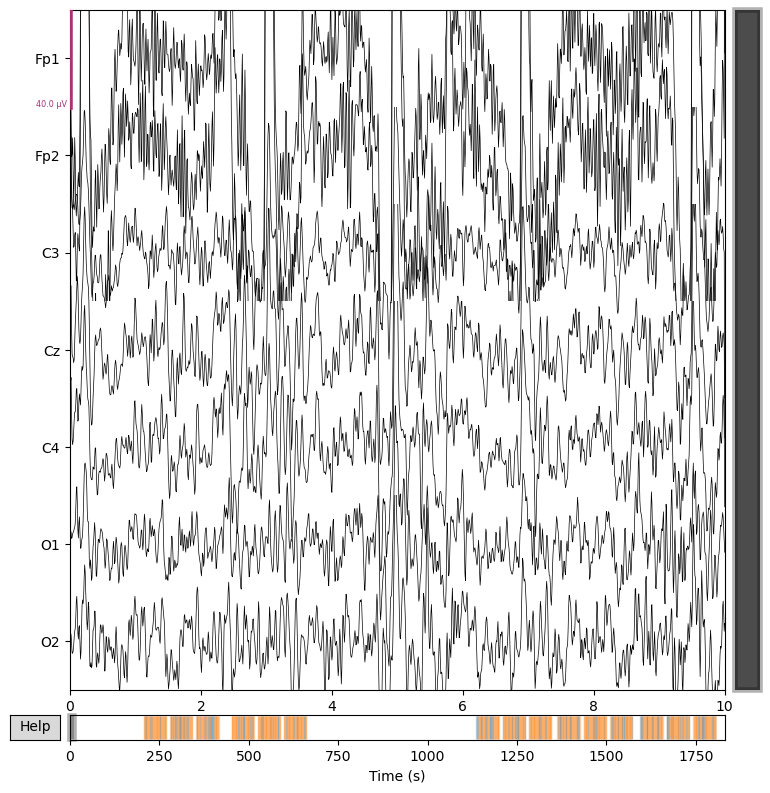

In [7]:
raw.plot(highpass=1, lowpass=30)

Plot power spectral density

Effective window size : 8.192 (s)


/opt/miniconda3/envs/workshop/lib/python3.10/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


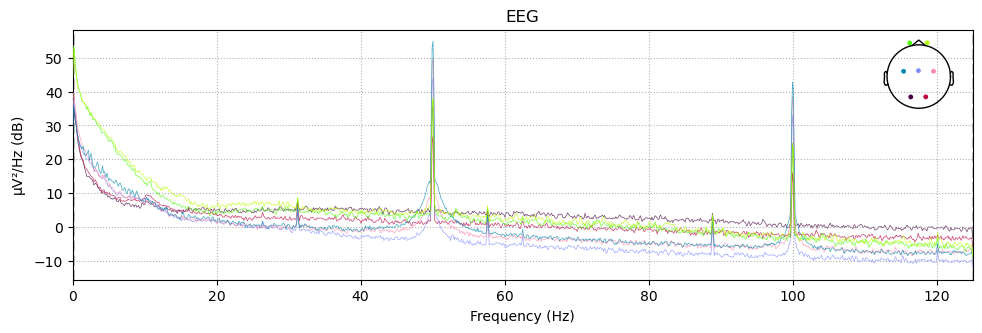

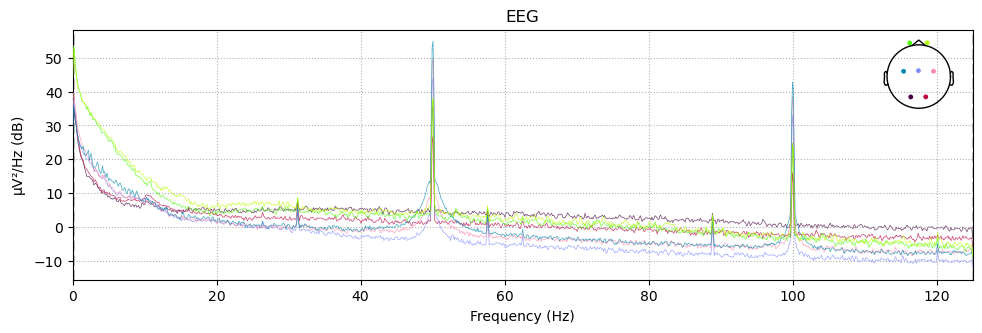

In [8]:
raw.compute_psd().plot(picks='data', exclude='bads')

Bandpass

In [9]:
raw.filter(1, 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)



<RawArray | 7 x 457888 (1831.5 s), ~24.5 MB, data loaded>

Make sure that the data was filtered correctly

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


/opt/miniconda3/envs/workshop/lib/python3.10/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


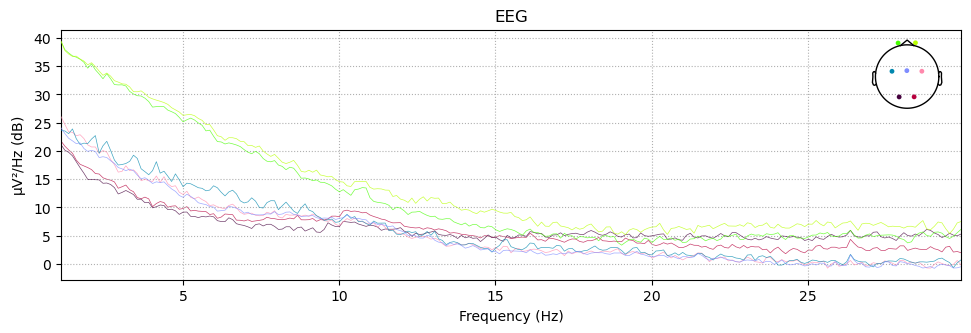

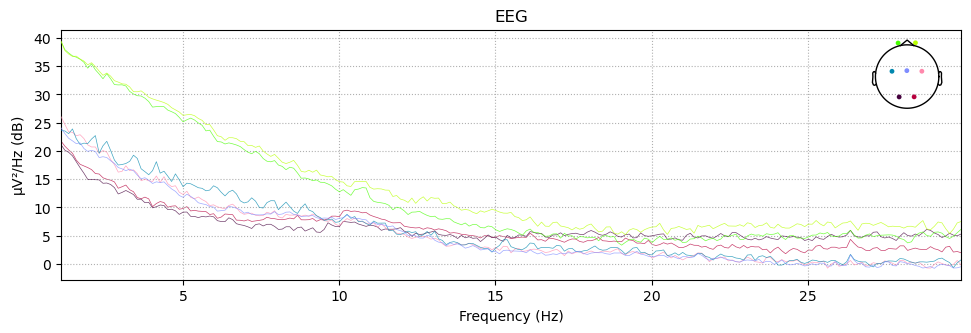

In [10]:
raw.plot_psd(fmin=1, fmax=30)

Extract epochs

In [11]:
events, event_id = mne.events_from_annotations(raw)
reject = {'eeg': 100e-6}
reject = None
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=-0.1, tmax=0.5, baseline=(-0.1, 0), reject=reject, preload=True, verbose=False)
#epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=-0.8, tmax=-0.4, baseline=None, reject=reject, preload=True, verbose=False)
print(f'Dropped: ', (1 - len(epochs.events)/len(events)) * 100, '%')
epochs

Used Annotations descriptions: ['deviant', 'standard']
Dropped:  0.0 %


Number of events,750
Events,deviant: 144standard: 606
Time range,-0.100 – 0.500 s
Baseline,-0.100 – 0.000 s


Plot conditions for each channels

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


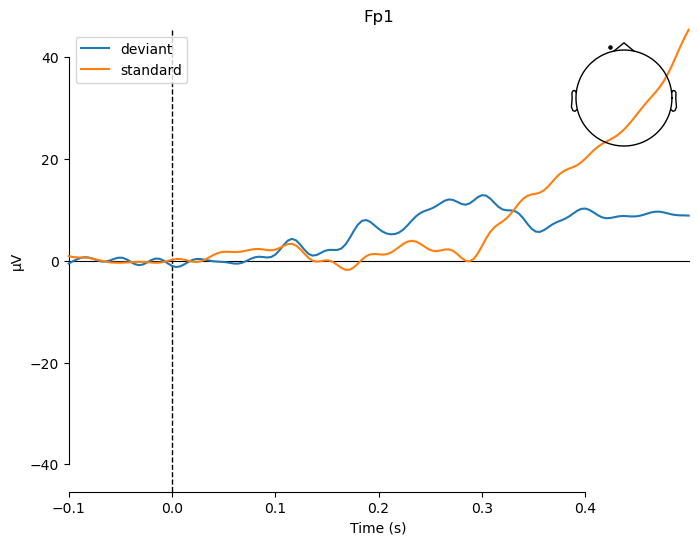

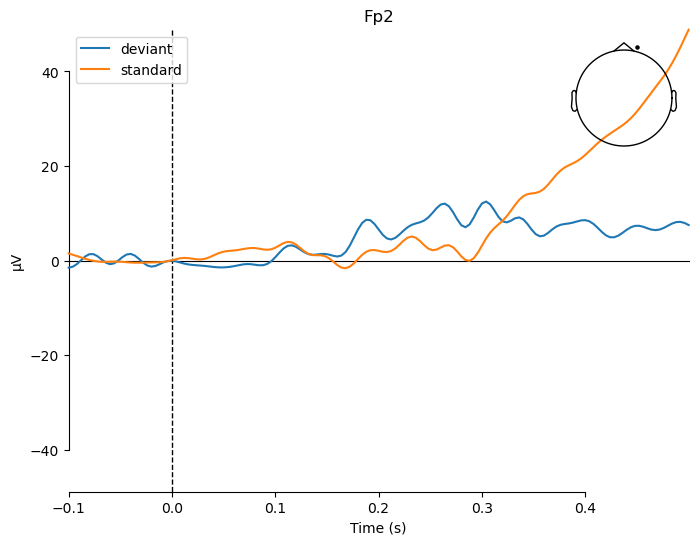

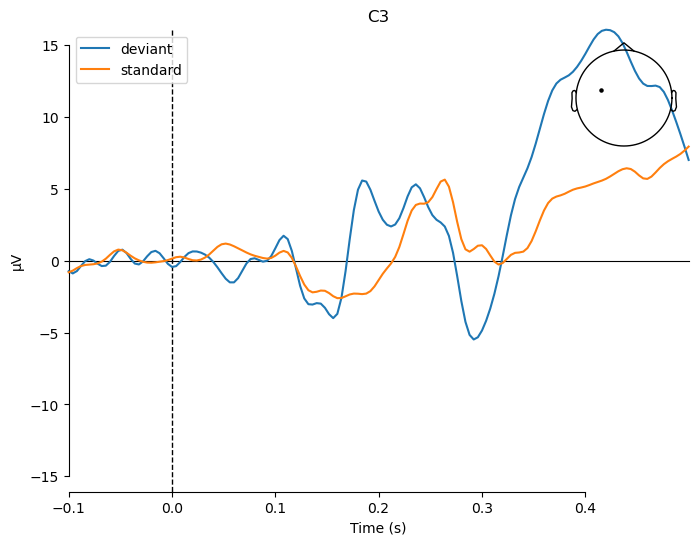

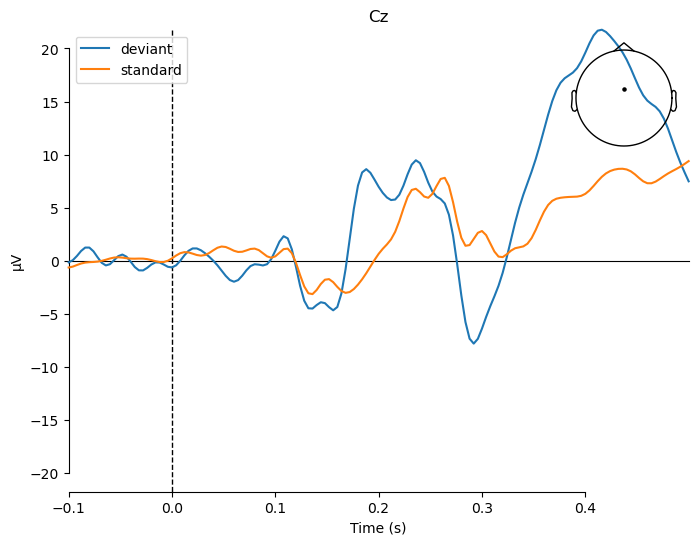

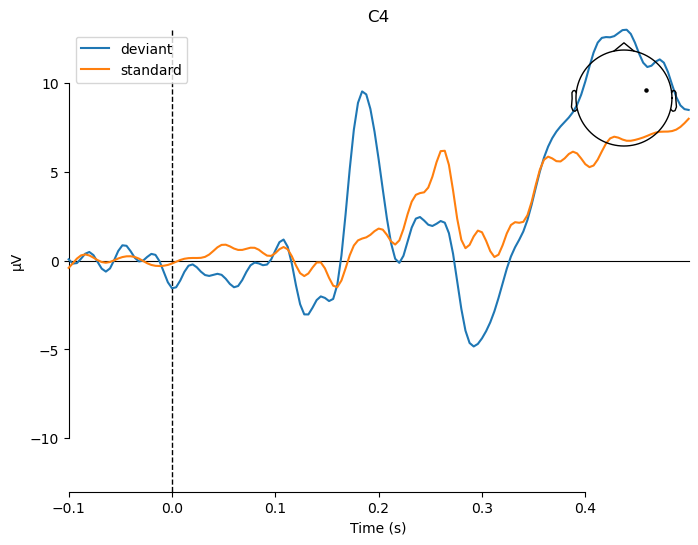

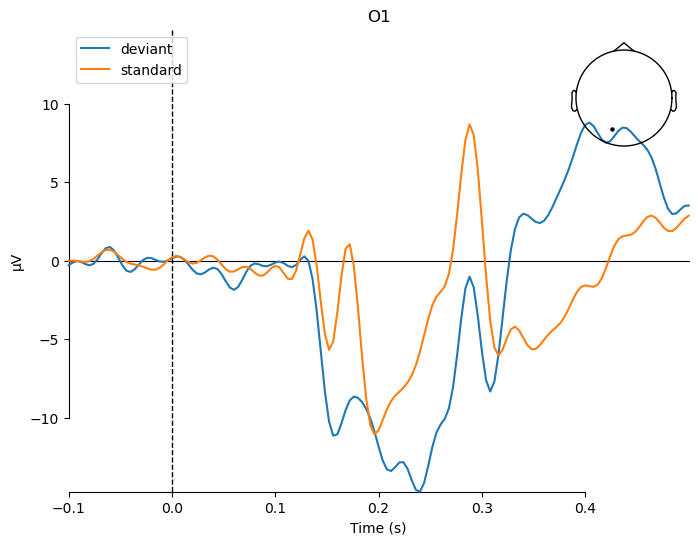

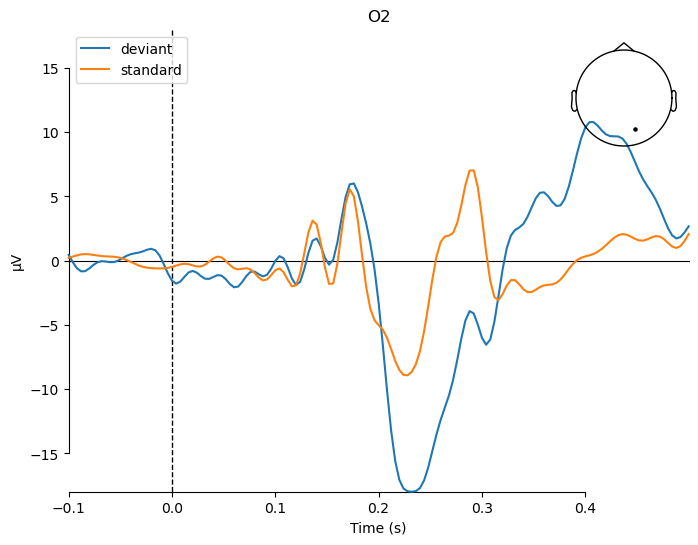

In [12]:
conditions = event_id.keys()
evoked = {condition: epochs[condition].average() for condition in conditions}
#mne.viz.plot_compare_evokeds(evoked, axes='topo')    
for index, channel in enumerate(raw.ch_names):
    mne.viz.plot_compare_evokeds(evoked, picks=[index])

## Classification

In [13]:
clfs = {}
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TSclassifier(metric='riemann', tsupdate=False))
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM(metric='riemann'))
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(nfilter=8, estimator='oas'), TSclassifier(metric='riemann', tsupdate=False))
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(nfilter=8, estimator='oas'), MDM(metric='riemann'))

X = epochs.get_data() * 1e6
y = epochs.events[:, -1] == 1

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1)

results = {}
for method in clfs:
    results[method] = cross_val_score(clfs[method], X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

(0.0, 1.0)

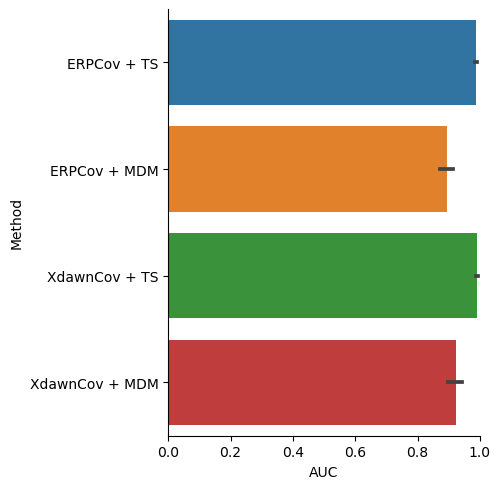

In [14]:
r = pd.DataFrame.from_dict(results).stack().reset_index().rename(columns={'level_1': 'Method', 0: 'AUC'})
sns.catplot(x='AUC', y='Method', data=r, kind='bar')
plt.xlim(0, 1)

In [15]:
best = {'method': None, 'clf': None, 'auc': 0}
scores_xval = {}
for method, score in results.items():
    score = np.mean(score)
    scores_xval[method] = score
    print(f'{method}\t{score}')
    if score >= best['auc']:
        best['method'] = method
        best['clf'] = clfs[method]
        best['auc'] = score
print(f'\nBest: {best["method"]}')

ERPCov + TS	0.9878597891137078
ERPCov + MDM	0.8945568538045029
XdawnCov + TS	0.9897976631518952
XdawnCov + MDM	0.9222285551439156

Best: XdawnCov + TS


In [16]:
clf = clfs['ERPCov + TS'].fit(X[0:500], y[0:500])
pred = clfs['ERPCov + TS'].predict(X[500:750])
print(classification_report(y[500:750], pred))
print(print("AUC: ", roc_auc_score(y[500:750], pred)))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98       198
        True       1.00      0.83      0.91        52

    accuracy                           0.96       250
   macro avg       0.98      0.91      0.94       250
weighted avg       0.97      0.96      0.96       250

AUC:  0.9134615384615384
None
